<img src="https://media1.tenor.com/images/fe60b63a65f989c4b41d6e742297e9dd/tenor.gif?itemid=21465770" width=750>

In a PUBG game, up to 100 players start in each match (matchId). Players can be on
teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how
many other teams are still alive when they are eliminated. In game, players can pick up
different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim,
run, shoot, and experience all of the consequences -- such as falling too far or running
themselves over and eliminating themselves.
You are provided with a large number of anonymized PUBG game stats, formatted so that
each row contains one player&#39;s post-game stats. The data comes from matches of all
types: solos, duos, squads, and custom; there is no guarantee of there being 100 players
per match, nor at most 4 player per group.
You must create a model which predicts players&#39; finishing placement based on their final
stats, on a scale from 1 (first place) to 0 (last place).

# **Domain analysis**

* **Id**- Player’s Id
*   **groupId** - ID to identify a group within a match. If the same group of 
players plays in different matches, they will have a different groupId each time.
* **matchId** - ID to identify match.
*  **assists** - Number of enemy players this player damaged that were killed by teammates.
*  **boosts** - Number of boost items used.
* **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
* **DBNOs** - Number of enemy players knocked.
* **headshotKills** - Number of enemy players killed with headshots.
* **heals**- Number of healing items used
* **killPlace**- Ranking in match of number of enemy players killed.
* **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* **kills** - Number of enemy players killed
* **killStreaks** - Max number of enemy players killed in a short amount of time.
* **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* **matchDuration** - Duration of match in seconds.
* **matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”,“duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* **numGroups** - Number of groups we have data for in the match.
* **rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* **revives** - Number of times this player revived teammates.
* **rideDistance** - Total distance traveled in vehicles measured in meters
* **roadKills** - Number of kills while in a vehicle.
* **swimDistance** - Total distance traveled by swimming measured in meters.
* **teamKills** - Number of times this player killed a teammate.
* **vehicleDestroys** - Number of vehicles destroyed.
* **walkDistance** - Total distance traveled on foot measured in meters.
* **weaponsAcquired** - Number of weapons picked up.
* **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


<img src="https://media1.tenor.com/images/a1f46044cbe733e5489860b75b44c560/tenor.gif?itemid=18253964" widh=5000>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statistics
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


### Memory Reducing technique:

In [3]:

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# **Reading Data**

In [4]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PUBG/pubg.csv')
data = reduce_mem_usage(data)
data

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.000,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.040,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.000,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.000,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.000,0,0,49.750000,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,1029,0,0,0.000000,1873,squad-fpp,29,28,-1,0,1292.0000,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,0,0,0,0.000000,1435,solo,93,93,1501,0,0.0000,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,0,0,0,0.000000,1321,squad-fpp,28,28,1500,0,0.0000,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,0,2,1,98.500000,1373,squad-fpp,26,25,1418,2,0.0000,0,0.000,0,0,2748.000000,8,0,0.8000


The data consists of 4446966 rows × 29 columns

#**Basic Checks**

In [5]:
df=data.copy()

### **head of the data:**

In [6]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


### **Tail of the data:**

In [7]:
df.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.000000,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.699997,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.700012,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.000000,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.000000,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.000000,5,0,0.5464


### **Shape of the data:**

In [8]:
df.shape

(4446966, 29)

### **Describe the numerical data:**

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.000000,0.000000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.000000,0.000000,2.000000,33.0
damageDealt,4446966.0,130.633118,169.886948,0.0,0.000000,84.239998,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.000000,0.000000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.000000,0.000000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.000000,0.000000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.000000,47.000000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.000000,0.000000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.000000,0.000000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.000000,0.000000,1.000000,20.0


**Describe the categorical data:**

In [10]:
df.describe(include=['O'])

,Id,groupId,matchId,matchType
count,4446966,4446966,4446966,4446966
unique,4446966,2026745,47965,16
top,860b39e63d3584,14d6b54cdec6bc,e23056639b3d7e,squad-fpp
freq,1,74,100,1756186


### **column names of the data:**

In [11]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

### **Information of the data:**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

### **Number of Null values in the data:**

In [13]:
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

### **numerical features:**

In [14]:

num_fea=[n for n in df.columns if df[n].dtypes!=object ]
num_fea

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']

### **categorical features:**

In [15]:

cat_columns=[n for n in df.columns if df[n].dtypes=='object']
cat_columns

['Id', 'groupId', 'matchId', 'matchType']

#**univarite analysis:**

DataPrep for basics statistical analysis

In [18]:
#install dataaprep
!pip install dataprep

In [19]:
from dataprep.eda import create_report
create_report(data)

Output hidden; open in https://colab.research.google.com to view.

### **Insights:**

## Overview
### Dataset Statistics
*   Number of Variables	29
*   Number of Rows	4.447×1006
*   Missing Cells	1
*   Missing Cells (%)	0.0%
*   Duplicate Rows	0
*   Duplicate Rows (%)	0.0%
*   Total Size in Memory	1.3 GB
*   Average Row Size in Memory	325.3 B
*   Variable Types	
*   Categorical: 5
*   Numerical: 24

## Id:
*   The Id is the players unique identity number.
*   There are 4446966 players are there in this dataset.

## groupId:
*   The groupId is the representation of which player is belongs to which group with a identity number of a group.
*   There are 2026745 groups are present in this dataset.
*   The higest players are involved inthis :
         *   '14d6b54cdec6bc'(74players)
*   The lowest players are involved inthis following groups.
          *  e4b04aa4df2199   -   1(player)
          *   d620e110128a23   -  1(player)
          *   92834abd8e2fc9   -  1(player)
          *   8032415dec0a2d    - 1(player)
          *   93575339a2e411   -  1(player)






            
            
            














## matchId:

In [20]:
df.groupby('matchId')['matchId'].transform('count')

0          96
1          91
2          98
3          91
4          97
           ..
4446961    94
4446962    93
4446963    98
4446964    94
4446965    98
Name: matchId, Length: 4446966, dtype: int64


*   MatchId is about the match number.
*   There are 47965 matchs are played by this players.
*   maximum players in a match is 100.
*   In this following matches 100 players are played
        *   31c6896f9af308    100(players)
        *  e387ce667eb006    100(players)
        *   8c915e7ab81337    100(players)
        *  b6fd24afe6dfd5    100(players)
        *  7a16014fbd913d    100(players)
*   In this following matche 1 player are played
        *  224a123c53e008      1(players)

#### Players joined

>This is likely a very valuable feature for our model. If we know how many people are in a match we can normalize other features and get stronger predictions on individual players.

In [21]:
df['playersjoined']= df.groupby('matchId')['matchId'].transform('count')

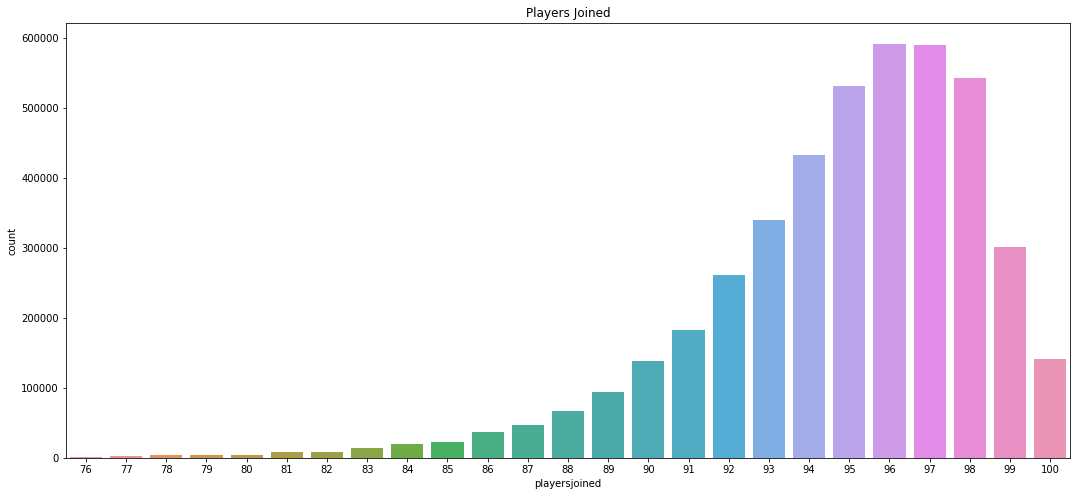

In [22]:
plt.figure(figsize=(18,8))
sns.countplot(df[df['playersjoined']>75]['playersjoined'])
plt.title('Players Joined')
plt.show()

>As we can see, There are a few matches with fewer than 75 players that are not displayed here. As you can see most of the matches are nearly packed a have nearly 100 players. It is nevertheless interesting to take these features into our analysis.

### **matchType:**


>There are 3 game modes in the game. One can play solo, or with a friend (duo), or with 3 other friends (squad).

In [23]:
m_types = df.loc[:,"matchType"].value_counts().to_frame().reset_index()
m_types.columns = ["Type","Count"]
m_types

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536762
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


>In PUBG there are essentially three main modes of game: Solo, Duo and Squad.

>In a squad mode, you play in a group of 4 players. Here we can see that the match types are further broken down taking into account view modes:

>FPP - First Person Perspective

>TPP - Thirst Peron Perspective

>Normal - you can switch between views during a game However, We are not able to identify what flare- and crash- types of matches are.

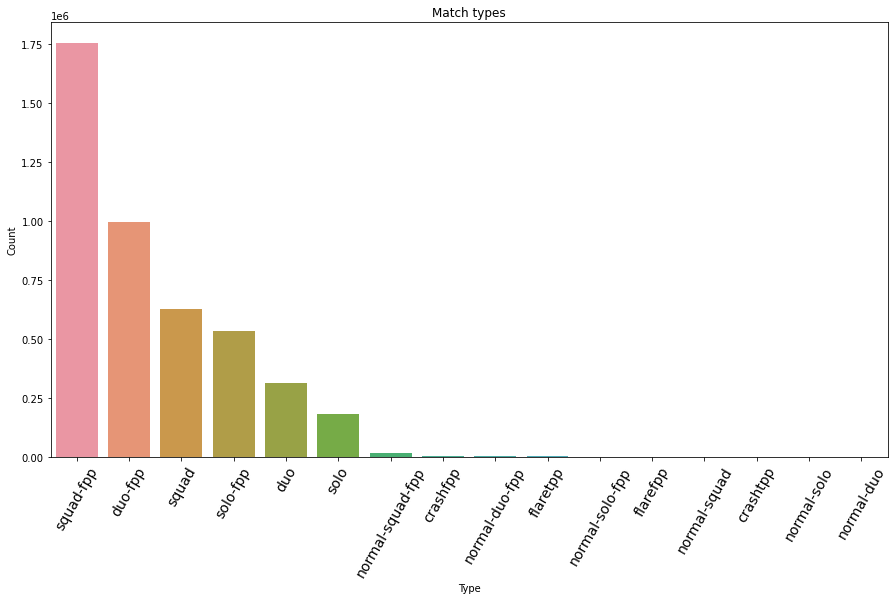

In [24]:
plt.figure(figsize=(15,8))
ticks = m_types.Type.values
ax = sns.barplot(x="Type", y="Count", data=m_types)
ax.set_xticklabels(ticks, rotation=60, fontsize=14)
ax.set_title("Match types")
plt.show()

In [25]:
#print(data.matchType.value_counts())
labels = ['squad-fpp ','duo-fpp','squad','solo-fpp','duo','solo','normal-squad-fpp','crashtpp','normal-duo-fpp','flarefpp','normal-solo-fpp','flaretpp','normal-squad','crashfpp','normal-solo','normal-duo'] 
values=[1756186,996691,626526,536762,313591,181943,17174,6287,5489,2505,1682, 718,516,371,326,199]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=8)
fig.show()

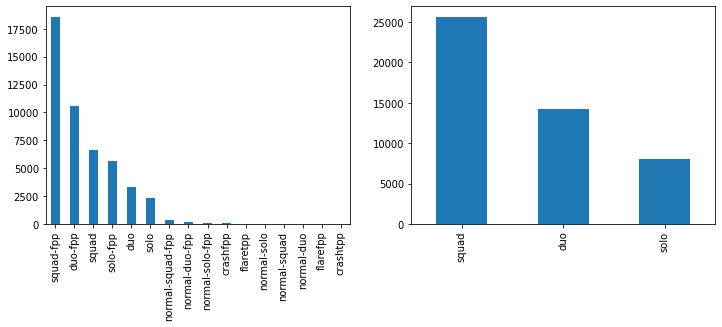

In [26]:
fig, ax= plt.subplots(1,2, figsize=(12,4))
df.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])
mapper= lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
df['matchType']=df['matchType'].apply(mapper)
df.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

### Insights:
>Max players at matchType is squad-fpp

>min players at  match is normal-duo

>solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp

>duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp

>squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp

In [27]:
m_types2 = data.loc[:,"matchType"].value_counts().to_frame()
aggregated_squads = m_types2.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
aggregated_duos = m_types2.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
aggregated_solo = m_types2.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
aggregated_mt = pd.DataFrame([aggregated_squads,aggregated_duos,aggregated_solo], index=["squad","duo","solo"], columns =["count"])
aggregated_mt

,count
squad,2400402
duo,1315970
solo,720713


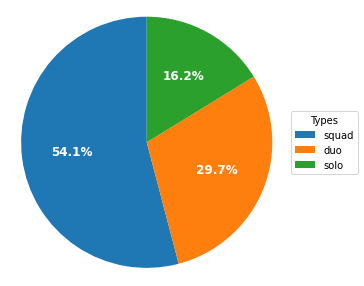

In [28]:
fig1, ax1 = plt.subplots(figsize=(5, 5))
labels = ['squad', 'duo', 'solo']

wedges, texts, autotexts = ax1.pie(aggregated_mt["count"],textprops=dict(color="w"), autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
ax1.legend(wedges, labels,
          title="Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
plt.show()

>The pie chart above shows that over 54% of all the matches was played in squad mode.

In [29]:
solos = df[df['numGroups']>50]
duos = df[(df['numGroups']>25) & (df['numGroups']<=50)]
squads = df[df['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(df), len(duos), 100*len(duos)/len(df), len(squads), 100*len(squads)/len(df),))

There are 709111 (15.95%) solo games, 3295326 (74.10%) duo games and 442529 (9.95%) squad games.


### **assists:**

In [30]:
assist=data['assists'].value_counts().sort_values(ascending=False)
print(assist)

0     3667660
1      591883
2      137144
3       35640
4        9990
5        2892
6         976
7         387
8         185
9          84
10         48
11         27
12         20
13         16
15          7
14          2
17          2
20          1
21          1
22          1
Name: assists, dtype: int64


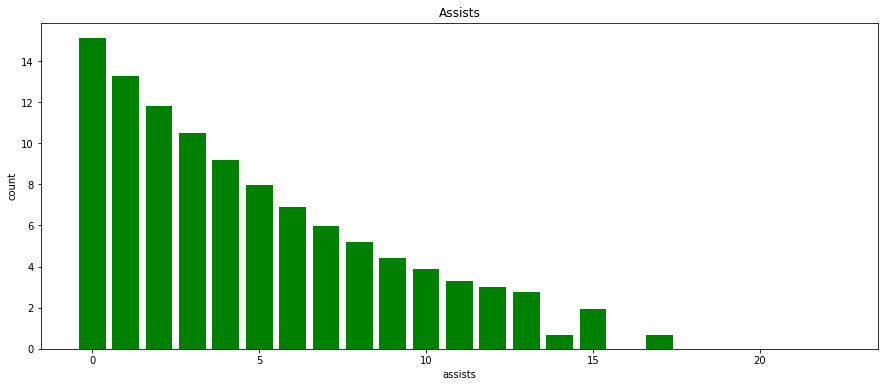

In [31]:
figure(figsize=(15, 6))
plt.bar(assist.index,np.log(assist.values),color=['green'])
plt.xlabel('assists')
plt.ylabel('count')
plt.title('Assists')
plt.show()


Mean of assists is : 0.23381492010507837
Max values of assists 22
Min values of assists 0


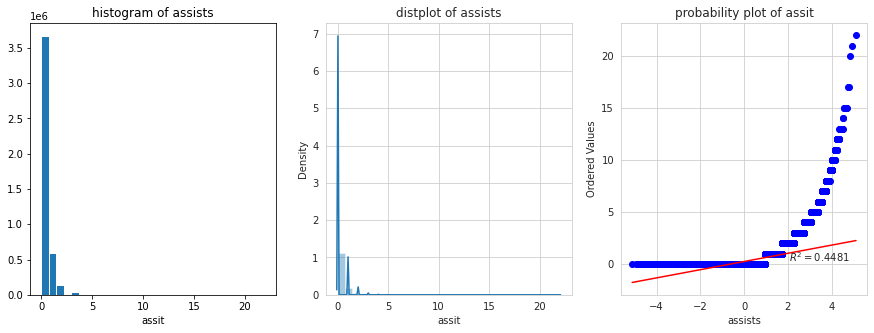

In [32]:
plt.figure(figsize=(15,5))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.assists,bins=30)
plt.title('histogram of assists')
plt.xlabel('assit')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.assists,bins=30)
plt.title('distplot of assists')
plt.xlabel('assit')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.assists,plot=plt,rvalue=True)
plt.title('probability plot of assit')
plt.xlabel('assists')
assists=statistics.mean(df.assists)
max=df.assists.max()
min=df.assists.min()
print("Mean of assists is :", assists )
print("Max values of assists",max)
print("Min values of assists",min)

### **Insights:**

Assist means to help, In PUBG  if you have given damage to the enemy and your team-mate kills the same enemy as you have done some damage on it then it is counted as Assist Kill as both you and your team-mate as taken down the enemy.

By the above plot, we analyised as follows:
*    The assist kill count is more at the 0(zero). It mean that players are not help eachother.
*   Only one player('be4ff9afaa5bb1') get higest 22 assists count value.

### **Boosts:**

<img src='https://i.ytimg.com/vi/5OZIEDHZBk8/hqdefault.jpg' height= 350 width=500  align='center'>

In [33]:
boost=data['boosts'].value_counts().sort_values(ascending=False)
print(boost)

0     2521324
1      680252
2      491316
3      295883
4      195729
5      120271
6       70111
7       37626
8       18893
9        8638
10       3992
11       1644
12        726
13        295
14        126
15         62
16         30
17         16
18         13
19          6
21          4
20          3
24          2
23          1
28          1
22          1
33          1
Name: boosts, dtype: int64


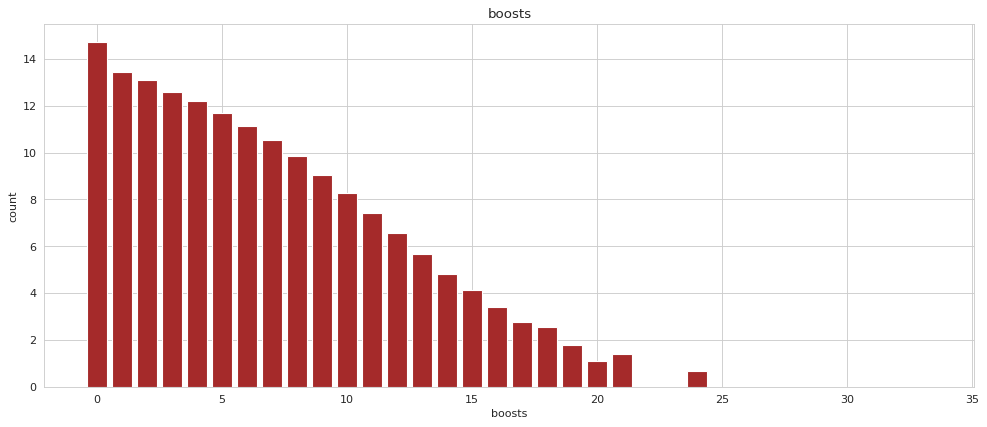

In [34]:
figure(figsize=(15, 6), dpi=80)
plt.bar(boost.index,np.log(boost.values),color=['brown'])
plt.xlabel('boosts')
plt.ylabel('count')
plt.title('boosts')
plt.show()



Mean of boosts is : 1.1069077209045448
Max values of boosts 33
Min values of boosts 0


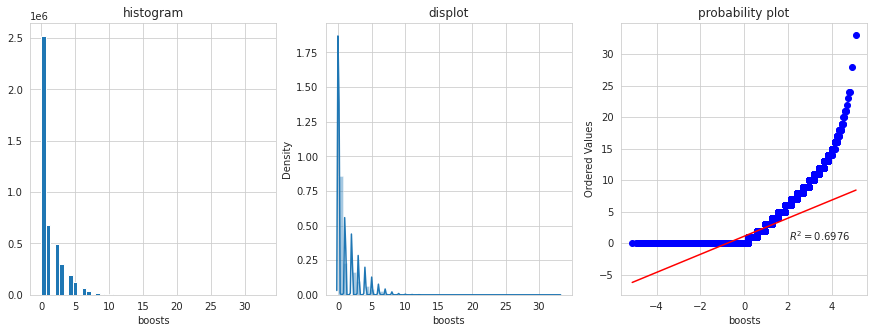

In [35]:
plt.figure(figsize=(15,5))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.boosts,bins=50)
plt.title('histogram')
plt.xlabel('boosts')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.boosts,bins=50)
plt.title('displot')
plt.xlabel('boosts')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.boosts,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('boosts')
boosts=statistics.mean(df.boosts)
max=df.boosts.max()
min=df.boosts.min()
print("Mean of boosts is :", boosts)
print("Max values of boosts",max)
print("Min values of boosts",min)

### **Insights:**
>Boost indicates the number of times of using boosting items such as energy drink, which will help increase the moving speed and recover the health point slowly.
*   Min value of Boosts is:  0
*   Max value of Boosts is:  33

>2521324 players at min value of boost. It mean, that they didnot have any boost item.

>only 1 player at max value of boost. It mean, that they have highest boost value.


### **damageDealt**

Mean of damageDealt is : 130.71713789871578
Max values of damageDealt 6616.0
Min values of damageDealt 0.0


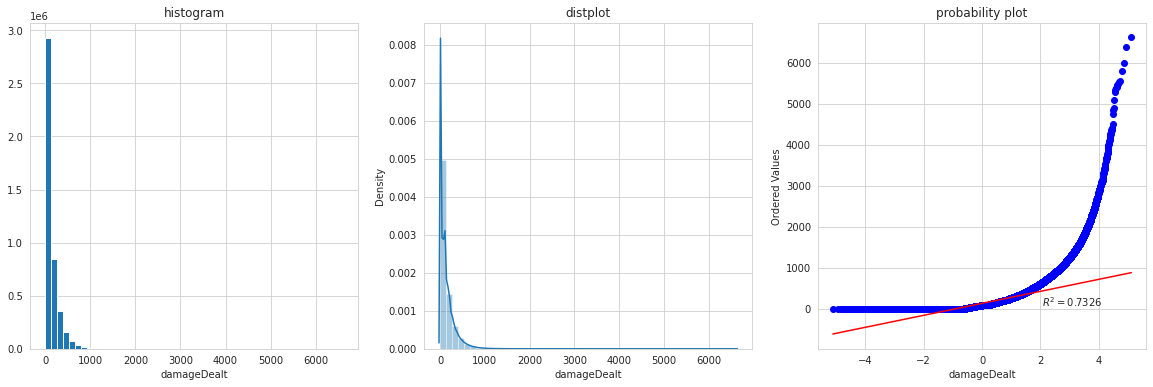

In [36]:
plt.figure(figsize=(20,6))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
df['damageDealt'].hist(bins=50,)
plt.title('histogram')
plt.xlabel('damageDealt')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.damageDealt,bins=50)
plt.title('distplot')
plt.xlabel('damageDealt')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.damageDealt,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('damageDealt')
damageDealt=statistics.mean(df.damageDealt)
max=df.damageDealt.max()
min=df.damageDealt.min()
print("Mean of damageDealt is :", damageDealt)
print("Max values of damageDealt",max)
print("Min values of damageDealt",min)

### **Insights:**
>DamageDealt indicates the total amount of damage that player makes. The damage that players hurt themselves (such as throwing buring bottle but accidently hurt themselves) is not included.

>1238102 players at min value of damagedealut.

>only 1 player at max value of damagedealut.

### **DBNOs**

In [37]:
DB=data['DBNOs'].value_counts().sort_values(ascending=False)
print(DB)

0     2773735
1      983281
2      395119
3      162682
4       69307
5       31686
6       14977
7        7291
8        3694
9        1966
10       1110
11        643
12        466
13        275
14        177
15        137
16         87
17         80
18         64
19         34
20         30
21         26
22         18
25         16
23         14
26         11
24         10
33          7
27          6
28          3
31          3
32          3
39          2
40          1
30          1
29          1
38          1
35          1
53          1
Name: DBNOs, dtype: int64


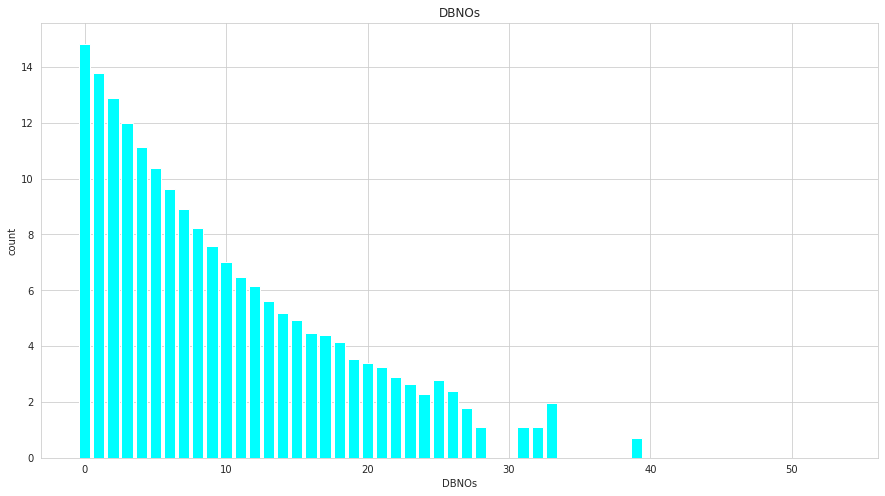

In [38]:

figure(figsize=(15,8))
plt.bar(DB.index,np.log(DB.values),color=['cyan'])
plt.xlabel('DBNOs')
plt.ylabel('count')
plt.title('DBNOs')
plt.show()


Mean of DBNOs is : 0.6578755043326169
Max values of DBNOs 53
Min values of DBNOs 0


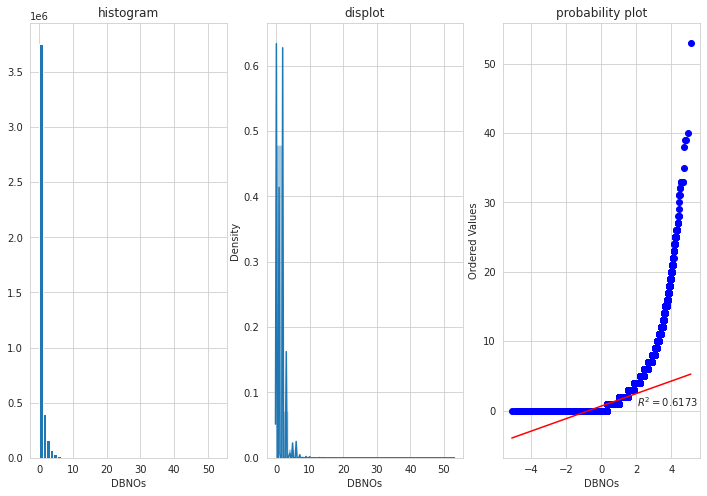

In [39]:
plt.figure(figsize=(12,8))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.DBNOs,bins=50)
plt.title('histogram')
plt.xlabel('DBNOs')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.DBNOs,bins=30)
plt.title('displot')
plt.xlabel('DBNOs')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.DBNOs,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('DBNOs')
DBNOs=statistics.mean(df.DBNOs)
max=df.DBNOs.max()
min=df.DBNOs.min()
print("Mean of DBNOs is :", DBNOs)
print("Max values of DBNOs",max)
print("Min values of DBNOs",min)

### **Insights:**
>DBNO indicates the number of enemies that the player knocks down. Knocking down enemies means making damage to them and their health points go down to zero.

> After that, the enemies can only crawl and will not be able to fight anymore except that their teammates cure them. If the player continue making damage to the knocked enemies and make their health points zero again, the enemies will be killed and eliminated.

>2773735 players at Min value of DBNOs.

>53 players at max value of DBNOs.

### **headshotKills**

<img src='https://media1.tenor.com/images/5409cda85a6a65c372c9d17997f92531/tenor.gif?itemid=12593379' width=400>

In [40]:
headshot=data['headshotKills'].value_counts().sort_values(ascending=False)
print(headshot)

0     3696116
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
20          3
23          3
26          3
21          2
27          2
31          2
34          2
41          1
39          1
46          1
35          1
42          1
40          1
64          1
Name: headshotKills, dtype: int64


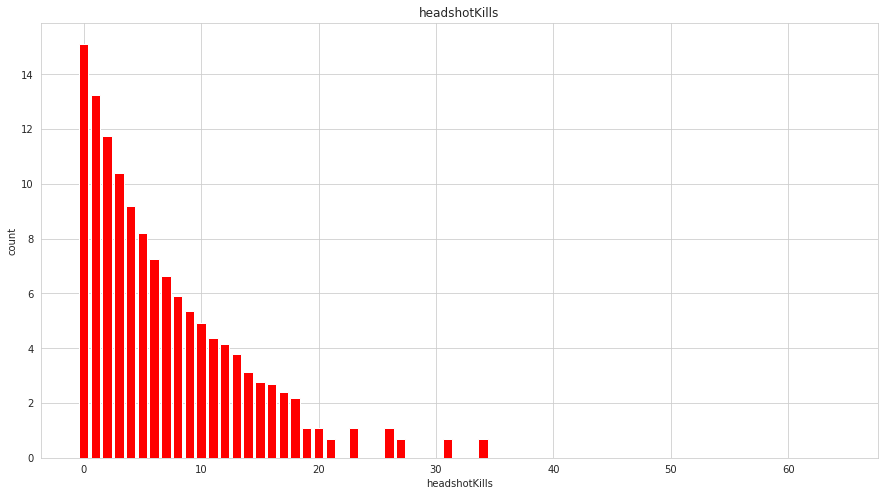

In [41]:

figure(figsize=(15,8))
plt.bar(headshot.index,np.log(headshot.values),color=['red'])
plt.xlabel('headshotKills')
plt.ylabel('count')
plt.title('headshotKills')
plt.show()


Mean of headshotKills is : 0.22681958890623405
Max values of headshotKills 64
Min values of headshotKills 0


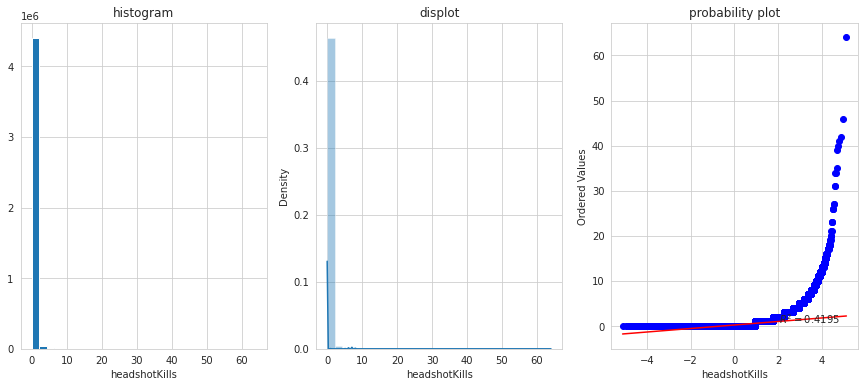

In [42]:
plt.figure(figsize=(15,6))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.headshotKills,bins=30)
plt.title('histogram')
plt.xlabel('headshotKills')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.headshotKills,bins=30)
plt.title('displot')
plt.xlabel('headshotKills')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.headshotKills,plot=plt,rvalue=True)
plt.xlabel('headshotKills')
plt.title('probability plot')
headshotKills=statistics.mean(df.headshotKills)
max=df.headshotKills.max()
min=df.headshotKills.min()
print("Mean of headshotKills is :", headshotKills)
print("Max values of headshotKills",max)
print("Min values of headshotKills",min)

### **Insights:**
If a player kill enemies by shooting their head, these kills will be counted as HeadShot Kills, which will make more damage than shooting other part of enemy's body.

3696116 at Min value of headshotkills.

only 1 player at max value of headshotkills.

### **heals:**

In [43]:
heal=data['heals'].value_counts().sort_values(ascending=False)
print(heal)

0     2648198
1      673077
2      319387
3      202370
4      142637
       ...   
57          1
56          1
62          1
63          1
80          1
Name: heals, Length: 63, dtype: int64


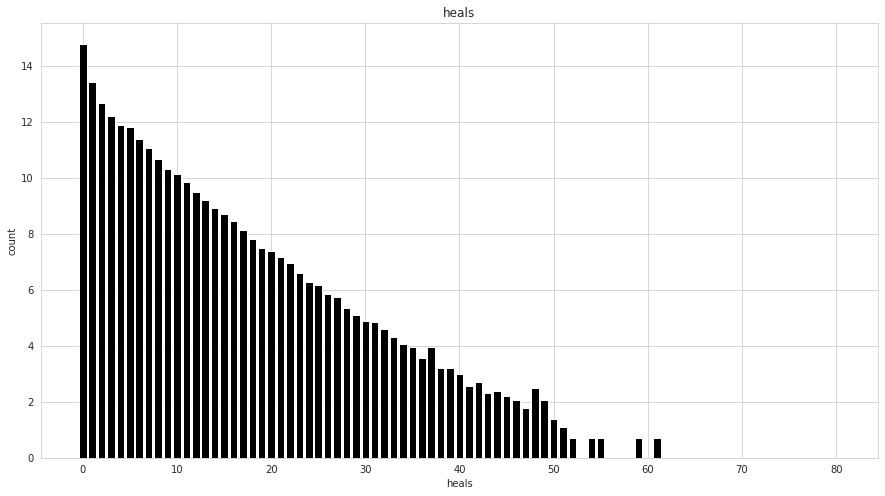

In [44]:
figure(figsize=(15,8))
plt.bar(heal.index,np.log(heal.values),color=['black'])
plt.xlabel('heals')
plt.ylabel('count')
plt.title('heals')
plt.show()


Mean of heals is : 1.370147196987789
Max values of heals 80
Min values of heals 0


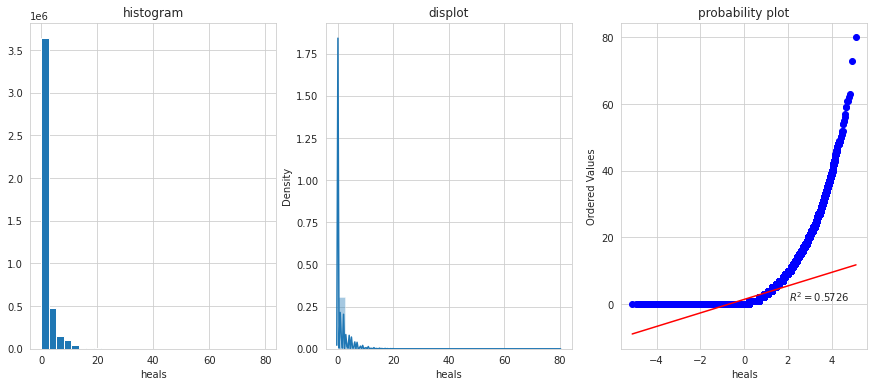

In [45]:
plt.figure(figsize=(15,6))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.heals,bins=30)
plt.title('histogram')
plt.xlabel('heals')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.heals,bins=30)
plt.xlabel('heals')
plt.title('displot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.heals,plot=plt,rvalue=True)
plt.xlabel('heals')
plt.title('probability plot')
heals=statistics.mean(df.heals)
max=df.heals.max()
min=df.heals.min()
print("Mean of heals is :", heals)
print("Max values of heals",max)
print("Min values of heals",min)

### **Insights:**
Heal indicates using healing items such as medical bandage, which will recover the health point instantly after waiting for casting time for several seconds.

2648198 at min value of heals.

only 1 one player at max value of heals.


### **killPlace**

Mean of killPlace is : 47.59935020865912
Max values of killPlace 101
Min values of killPlace 1


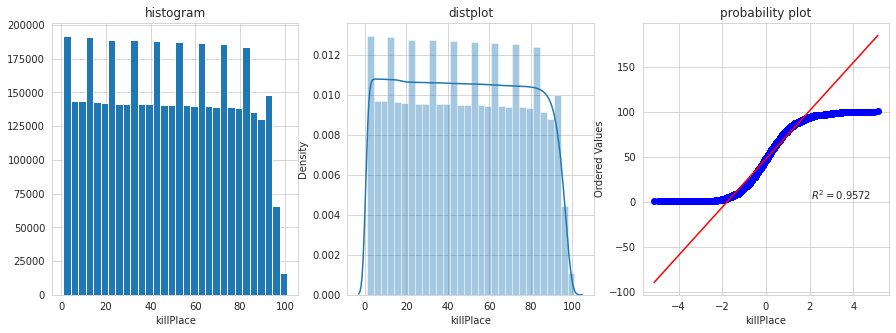

In [46]:
plt.figure(figsize=(15,5))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.killPlace,bins=30)
plt.title('histogram')
plt.xlabel('killPlace')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.killPlace,bins=30)
plt.title('distplot')
plt.xlabel('killPlace')
ax=plt.subplot(1,3,3)

sns.set_style(style="whitegrid")
stats.probplot(df.killPlace,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('killPlace')
killPlace=statistics.mean(df.killPlace)
max=df.killPlace.max()
min=df.killPlace.min()
print("Mean of killPlace is :", killPlace)
print("Max values of killPlace",max)
print("Min values of killPlace",min)

1      47965
2      47964
3      47962
4      47962
5      47962
       ...  
97     16080
98     10005
99      4461
100     1415
101        1
Name: killPlace, Length: 101, dtype: int64


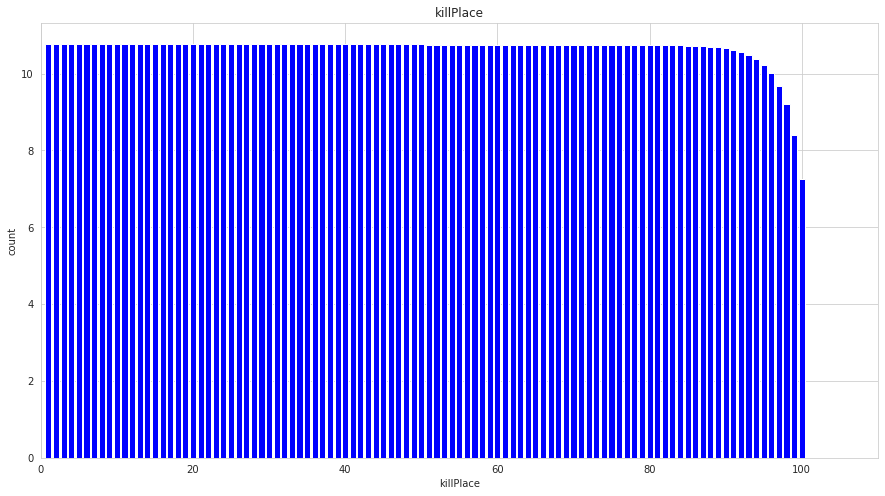

In [47]:
from pylab import *
killPlace=data['killPlace'].value_counts().sort_values(ascending=False)
print(killPlace)
figure(figsize=(15,8))
plt.bar(killPlace.index,np.log(killPlace.values),color=['blue'])
plt.xlabel('killPlace')
plt.ylabel('count')
xlim(0, 110,)
plt.title('killPlace')
plt.show()


### **Insights:**
>kill place indicates, player stands on which place or position of his kills on emenmy.

 >47965 palyers at min  value of killplace.
 
 >only 1 palyer at max value of killplace.

### **killPoints**

Mean of killPoints is : 505.00604209701623
Max values of killPoints 2170
Min values of killPoints 0


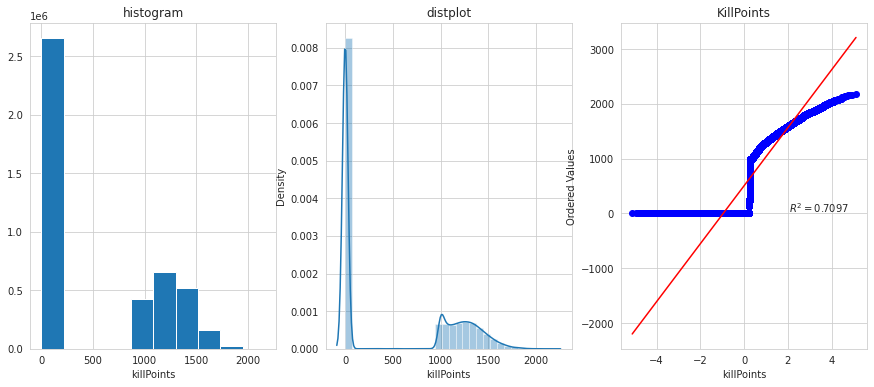

In [48]:
plt.figure(figsize=(15,6))
ax=plt.subplot(1,3,1)
plt.hist(df.killPoints)
plt.title('histogram')
plt.xlabel('killPoints')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.killPoints,bins=30)
plt.title('distplot')
plt.xlabel('killPoints')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.killPoints,plot=plt,rvalue=True)
plt.xlabel('killPoints')
plt.title('KillPoints')
killPoints=statistics.mean(df.killPoints)
max=df.killPoints.max()
min=df.killPoints.min()
print("Mean of killPoints is :",killPoints)
print("Max values of killPoints",max)
print("Min values of killPoints",min)

### **insights:**
>KillPoints indicates the number of point he/she are get on the basis of their kills on the enemies.

>2655647 at min value of the killpoints. These are donot have any points.

>only one player at max value of the kill points.

### **kills:**


<img src='https://r2.community.samsung.com/t5/image/serverpage/image-id/479020iD6C1F35DD146716E/image-size/large?v=1.0&px=999' width=300>

In [49]:
kills=data['kills'].value_counts().sort_values(ascending=False)

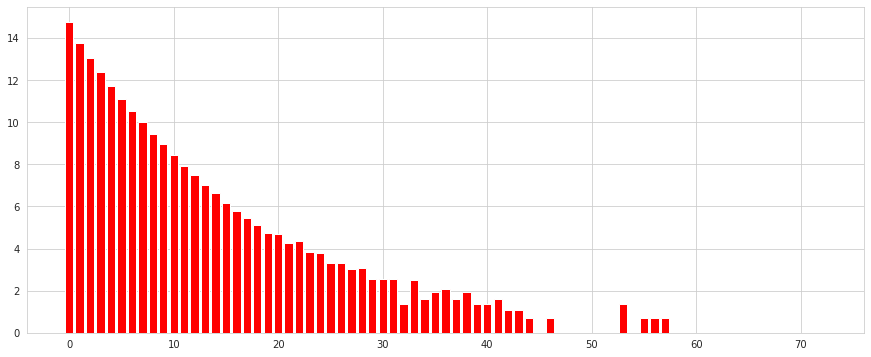

In [50]:
figure(figsize=(15, 6))
plt.bar(kills.index,np.log(kills.values),color=[ 'red', ])
plt.show()


Mean of kills is : 0.9247833241810259
Max values of Kills 72
Min values of Kills 0


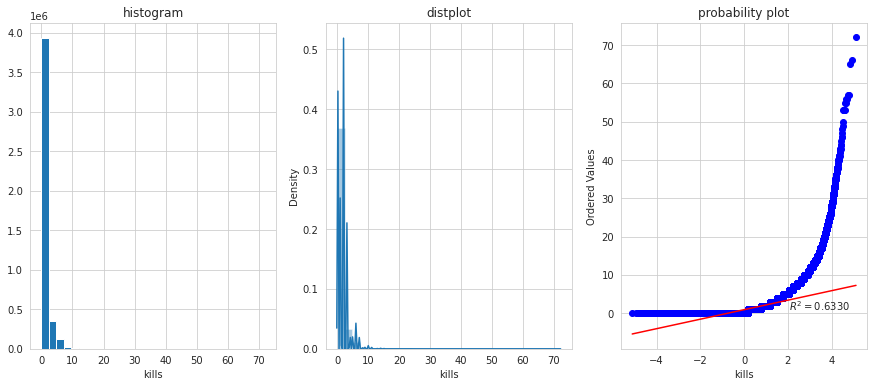

In [51]:
plt.figure(figsize=(15,6))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.kills,bins=30)
plt.title('histogram')
plt.xlabel('kills')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.kills,bins=30)
plt.title('distplot')
plt.xlabel('kills')
ax=plt.subplot(1,3,3)

sns.set_style(style="whitegrid")
stats.probplot(df.kills,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('kills')
kills=statistics.mean(df.kills)
max=df.kills.max()
min=df.kills.min()
print("Mean of kills is :",kills)
print("Max values of Kills",max)
print("Min values of Kills",min)

### **Insights:**
>Kills indicates, the number of  kills made by a player in the game.

>2529722 palyers didnot kill anyone.

>The higest kills is 72. It is done by only one player.

### **KillStreaks:**



0     2529722
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
12          5
13          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64


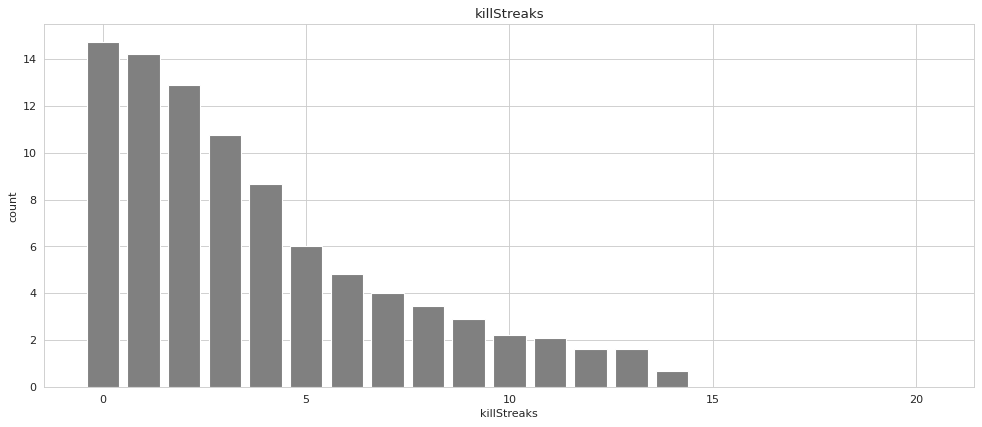

In [52]:
killStreaks=data['killStreaks'].value_counts().sort_values(ascending=False)
print(killStreaks)
figure(figsize=(15, 6), dpi=80)
plt.bar(killStreaks.index,np.log(killStreaks.values),color=['grey'])
plt.xlabel('killStreaks')
plt.ylabel('count')
plt.title('killStreaks')
plt.show()


Mean of killStreaks is : 0.543955137052993
Max values of killStreaks 20
Min values of killStreaks 0


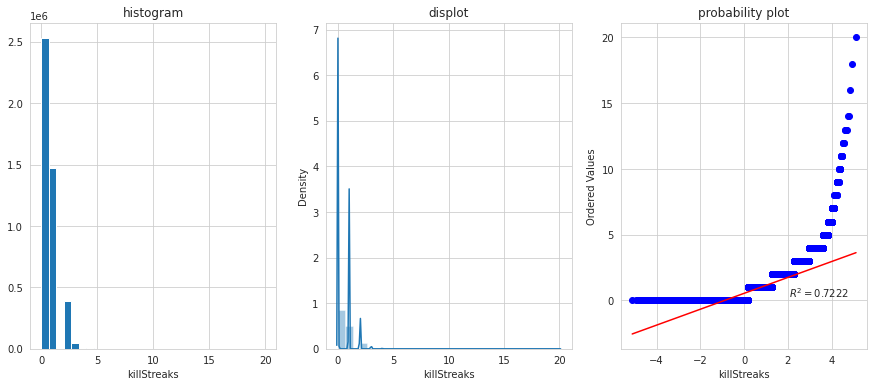

In [53]:
plt.figure(figsize=(15,6))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.killStreaks,bins=30)
plt.title('histogram')
plt.xlabel('killStreaks')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.killStreaks,bins=30)
plt.title('displot')
plt.xlabel('killStreaks')
ax=plt.subplot(1,3,3)

sns.set_style(style="whitegrid")
stats.probplot(df.killStreaks,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('killStreaks')
killStreaks=statistics.mean(df.killStreaks)
max=df.killStreaks.max()
min=df.killStreaks.min()
print("Mean of killStreaks is :",killStreaks)
print("Max values of killStreaks",max)
print("Min values of killStreaks",min)

### **Insights:**
>KillStreaks is the count of killing enemies continuously in a small range of time.

>2529722 players at Min value of KillStreaks.

>only one players at Max value of KillStreaks.

### **longestKill:**

Mean of longestKill is : 22.997594845306686
Max values of longestKill 1094.0
Min values of longestKill 0.0


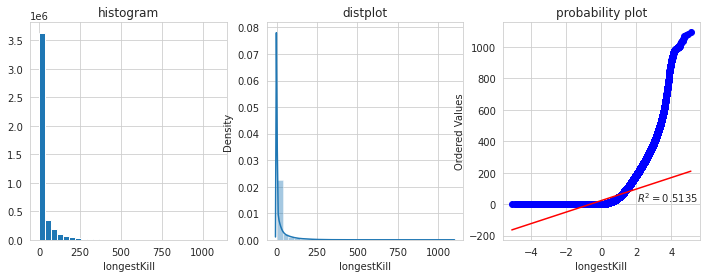

In [54]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.longestKill,bins=30)
plt.title('histogram')
plt.xlabel('longestKill')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.longestKill,bins=30)
plt.title('distplot')
plt.xlabel('longestKill')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.longestKill,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('longestKill')
longestKill=statistics.mean(df.longestKill)
max=df.longestKill.max()
min=df.longestKill.min()
print("Mean of longestKill is :",longestKill)
print("Max values of longestKill",max)
print("Min values of longestKill",min)

### **Insights:**
>LongestKill is the longest distance for the distance between a player and the enemy killed by him.

>2538735 players at min value of longestkill.

>only one player at max value of longestkill.

### **matchDuration**

Mean of matchDuration is : 1579.5064396714524
Max values of matchDuration 2237
Min values of matchDuration 9


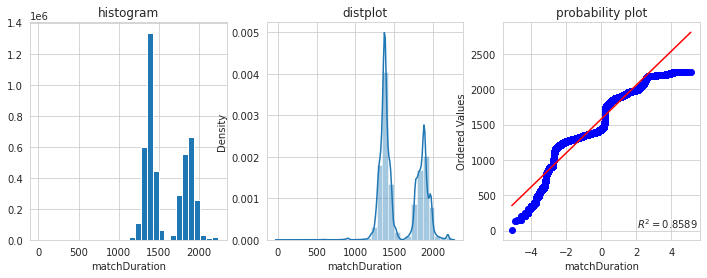

In [55]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.matchDuration,bins=30)
plt.title('histogram')
plt.xlabel('matchDuration')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.matchDuration,bins=30)
plt.xlabel('matchDuration')
plt.title('distplot')
ax=plt.subplot(1,3,3)

sns.set_style(style="whitegrid")
stats.probplot(df.matchDuration,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('matchDuration')
matchDuration=statistics.mean(df.matchDuration)
max=df.matchDuration.max()
min=df.matchDuration.min()
print("Mean of matchDuration is :",matchDuration)
print("Max values of matchDuration",max)
print("Min values of matchDuration",min)

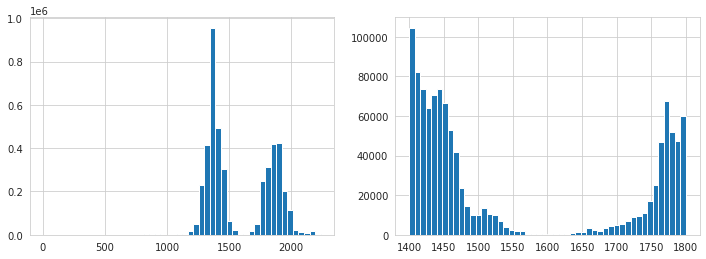

In [56]:
fig, ax= plt.subplots(1,2, figsize=(12,4))
df['matchDuration'].hist(bins=50, ax=ax[0])
df.query('matchDuration >= 1400 & matchDuration <= 1800')['matchDuration'].hist(bins=50, ax=ax[1])

### **Insights:**
>match duration indicates, the how long they played the game in sec.

>more players(27764-players) at 1384 value of matchduration.

>only one player at min value of match duration.

>97 players at max value of match duration


### **maxPlace**

28    626484
29    507492
27    495090
49    367991
48    329046
       ...  
59       118
58       116
56       112
61        61
53        53
Name: maxPlace, Length: 99, dtype: int64


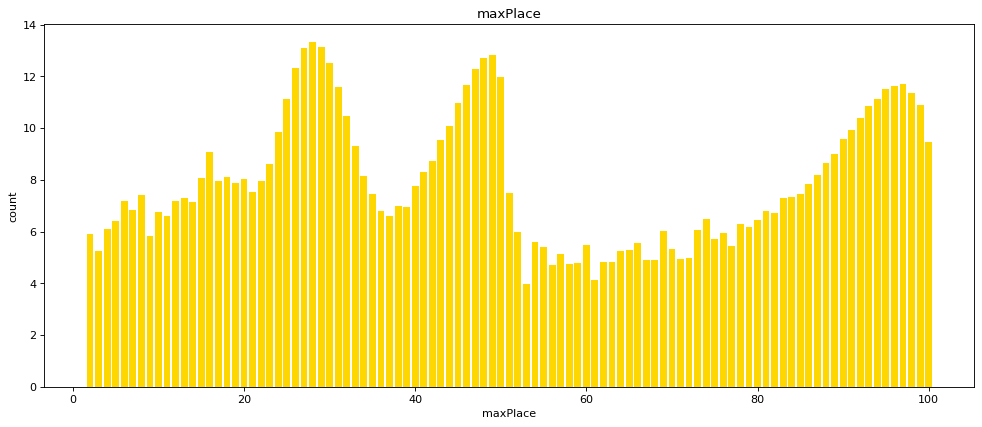

In [68]:
maxPlace=data['maxPlace'].value_counts().sort_values(ascending=False)
print(maxPlace)
figure(figsize=(15, 6), dpi=80)
plt.bar(maxPlace.index,np.log(maxPlace.values),color=['gold'])
plt.xlabel('maxPlace')
plt.ylabel('count')
plt.title('maxPlace')
plt.show()


Mean of maxPlace is : 44.504670150390176
Max values of maxPlace 100
Min values of maxPlace 1


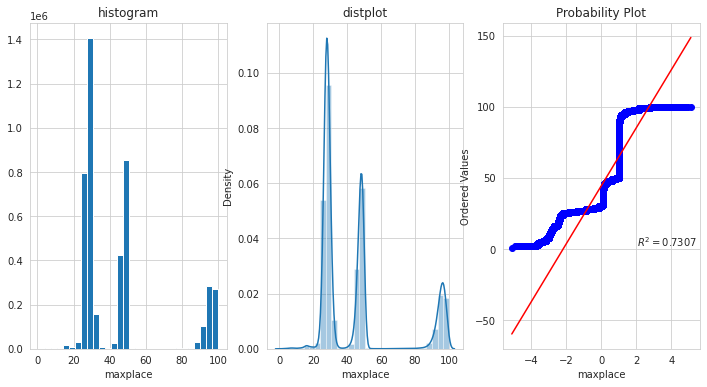

In [58]:
plt.figure(figsize=(12,6))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.maxPlace,bins=30)
plt.title('histogram')
plt.xlabel('maxplace')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.maxPlace,bins=30)
plt.title('distplot')
plt.xlabel('maxplace')
ax=plt.subplot(1,3,3)

sns.set_style(style="whitegrid")
stats.probplot(df.maxPlace,plot=plt,rvalue=True)

plt.xlabel('maxplace')
maxPlace=statistics.mean(df.maxPlace)
max=df.maxPlace.max()
min=df.maxPlace.min()
print("Mean of maxPlace is :",maxPlace)
print("Max values of maxPlace",max)
print("Min values of maxPlace",min)

### **Insights:**
>maxPlace indicates, maximum place reached inthe game.

>more player(626495) at 28 value of the maxPlace

>only one player at min value of max place.

>13100 players at Max value of maxPlace.

### **numGroups:**

27    537607
28    488669
26    416744
29    314665
47    269503
       ...  
54       112
66        85
62        64
57        58
55        56
Name: numGroups, Length: 100, dtype: int64


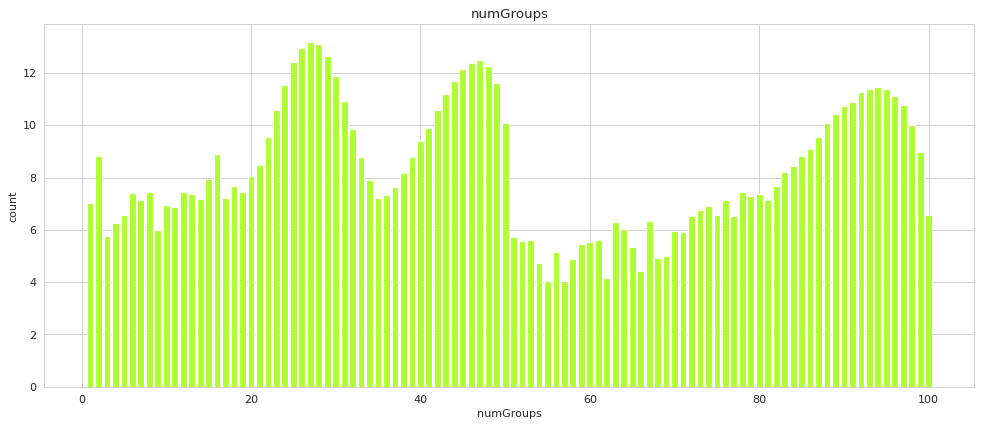

In [59]:
numGroups=data['numGroups'].value_counts().sort_values(ascending=False)
print(numGroups)
figure(figsize=(15, 6), dpi=80)
plt.bar(numGroups.index,np.log(numGroups.values),color=['greenyellow'])
plt.xlabel('numGroups')
plt.ylabel('count')
plt.title('numGroups')
plt.show()


Mean of numGroups is : 43.00759259234273
Max values of numGroups 100
Min values of numGroups 1


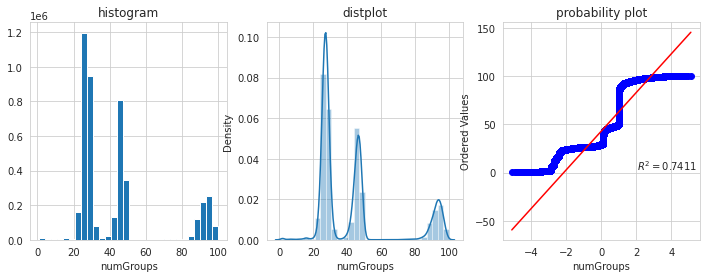

In [60]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.numGroups,bins=30)
plt.title('histogram')
plt.xlabel('numGroups')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.numGroups,bins=30)
plt.xlabel('numGroups')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.numGroups,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('numGroups')
numGroups=statistics.mean(df.numGroups)
max=df.numGroups.max()
min=df.numGroups.min()
print("Mean of numGroups is :",numGroups)
print("Max values of numGroups",max)
print("Min values of numGroups",min)

### **Insights:**
>num group indicates the number of group involved  in a match.

>more players(537607-players) at 27 value of numgroup.

>1147 players at minvalue of numGroup.

>700 palyers at max value of numgroup.

### **rankPoints:**

Mean of rankPoints is : 892.0104565674665
Max values of rankPoints 5910
Min values of rankPoints -1


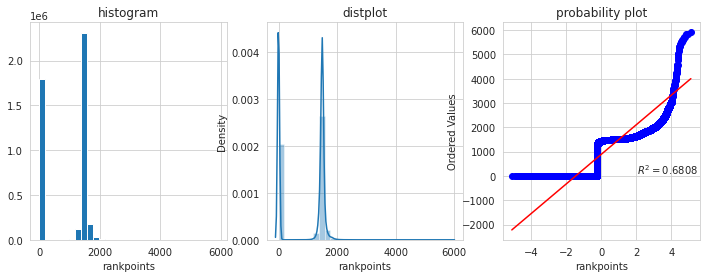

In [61]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.rankPoints,bins=30)
plt.title('histogram')
plt.xlabel('rankpoints')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.rankPoints,bins=30)
plt.xlabel('rankpoints')
plt.title('distplot')
ax=plt.subplot(1,3,3)

sns.set_style(style="whitegrid")
stats.probplot(df.rankPoints,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('rankpoints')
rankPoints=statistics.mean(df.rankPoints)
max=df.rankPoints.max()
min=df.rankPoints.min()
print("Mean of rankPoints is :",rankPoints)
print("Max values of rankPoints",max)
print("Min values of rankPoints",min)

### **Insights:**
>rank points indicates, what is the rank of a player.

>-1 mens none. It mean that, more player donot have any rank in the game.

>1701810 player at min value of rankpoint.

>only one player at max value of rankpoint.

### **revives:**

0     3859867
1      470110
2       95545
3       17333
4        3102
5         606
6         142
7          72
8          43
9          26
10         25
11         23
15         13
12         12
14         10
13          7
18          7
16          6
17          6
19          3
23          3
20          2
28          1
32          1
39          1
Name: revives, dtype: int64


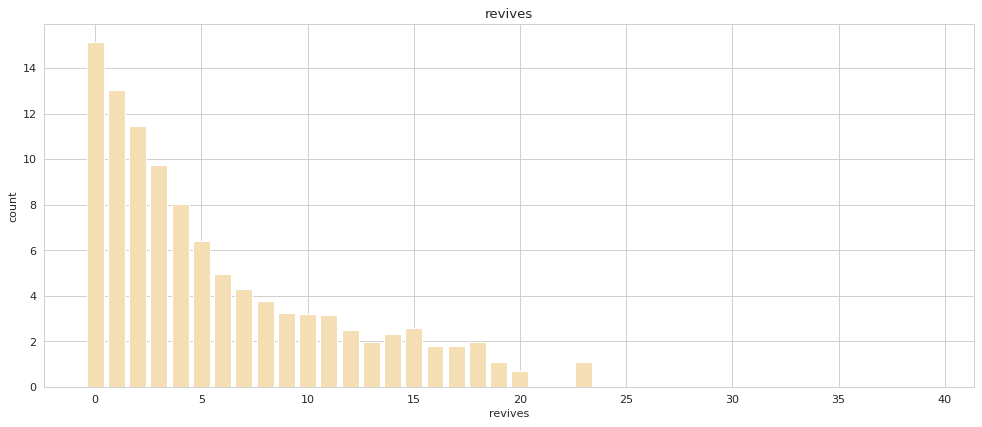

In [62]:
revives=data['revives'].value_counts().sort_values(ascending=False)
print(revives)
figure(figsize=(15, 6), dpi=80)
plt.bar(revives.index,np.log(revives.values),color=['wheat'])
plt.xlabel('revives')
plt.ylabel('count')
plt.title('revives')
plt.show()



In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.revives,bins=30)
plt.title('histogram')
plt.xlabel('revives')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.revives,bins=30)
plt.xlabel('revives')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.revives,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('revives')
revives=statistics.mean(df.revives)
max=df.revives.max()
min=df.revives.min()
print("Mean of revives is :",revives)
print("Max values of revives",max)
print("Min values of revives",min)

Mean of revives is : 0.16465900571310868
Max values of revives 39
Min values of revives 0


### **Insights:**
>Revives means the number of reviving teammates. If a teammate is knoekced down but not killed, player can revive that teammate and the count of reviving will be added one.

>3859867 players at min value of revives.

>only one player at max value of revives.


### **rideDistance:**

<img src='https://i.gifer.com/7JjV.gif' width=250>

In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.rideDistance,bins=30)
plt.title('histogram')
plt.xlabel('rideDistance')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.rideDistance,bins=30)
plt.xlabel('rideDistance')
plt.title('distplot')
ax=plt.subplot(1,3,3)
stats.probplot(df.rideDistance,plot=plt,rvalue=True)
plt.xlabel('probability plot')
plt.xlabel('rideDistance')
rideDistance=statistics.mean(df.rideDistance)
max=df.rideDistance.max()
min=df.rideDistance.min()
print("Mean of rideDistance is :",rideDistance)
print("Max values of rideDistance",max)
print("Min values of rideDistance",min)

### **Insights:**
RideDistance is the total travelling distance on vehicles.

3309429 players at max value of rideDistance.

only one player at min value of rideDistance.

### **roadKills:**

In [ ]:
roadKills=data['roadKills'].value_counts().sort_values(ascending=False)
print(roadKills)
figure(figsize=(14, 6), dpi=80)
plt.bar(roadKills.index,np.log(roadKills.values),color=['wheat'])
plt.xlabel('roadKills')
plt.ylabel('count')
plt.title('roadKills')
plt.xlim([0,19,])
plt.show()


In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.roadKills,bins=30)
plt.title('histogram')
plt.xlabel('roadKills')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.roadKills,bins=30)
plt.xlabel('roadKills')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.roadKills,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('roadKills')
roadKills=statistics.mean(df.roadKills)
max=df.roadKills.max()
min=df.roadKills.min()
print("Mean of roadKills is :",roadKills)
print("Max values of roadKills",max)
print("Min values of roadKills",min)

### **insights:**
>RoadKills is the count of killing enemies when the player is in a vehicle.

>4433970 players at min vlaue of roadkills.

>only one player at max value of roadkills.

### **SwimDistance:**

<img src='https://thumbs.gfycat.com/EvenSpiffyFerret-max-1mb.gif' width=400>

In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.swimDistance,bins=30)
plt.title('histogram')
plt.xlabel('swimDistance')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.swimDistance,bins=30)
plt.xlabel('swimDistance')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.swimDistance,plot=plt,rvalue=True)
plt.xlabel('swimDistance')
plt.title('probability plot')
swimDistance=statistics.mean(df.swimDistance)
max=df.swimDistance.max()
min=df.swimDistance.min()
print("Mean of swimDistance is :",swimDistance)
print("Max values of swimDistance",max)
print("Min values of swimDistance",min)

### Insights:
>SwimDistance is the total travelling distance by swimming measured in meters.

>4157694 at min value of swimDistance.

>only one player at max value of swimDistance.

### teamKills:

In [ ]:
teamKills=data['teamKills'].value_counts().sort_values(ascending=False)
print(teamKills)
figure(figsize=(15, 6), dpi=80)
plt.bar(teamKills.index,np.log(teamKills.values),color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xlabel('teamKills')
plt.ylabel('count')
plt.title('teamKills')
plt.show()


In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.teamKills,bins=30)
plt.title('histogram')
plt.xlabel('teamKills')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.teamKills,bins=30)
plt.xlabel('teamKills')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.teamKills,plot=plt,rvalue=True)
plt.title('probability curve')
plt.xlabel('teamKills')
teamKills=statistics.mean(df.teamKills)
max=df.teamKills.max()
min=df.teamKills.min()
print("Mean of teamKills is :",teamKills)
print("Max values of teamKills",max)
print("Min values of teamKills",min)

### **Insights:**
>TeamKills indicates the count of a player killing teammates.

>Most of players doesnot made any kill through team.

>4350036 players at min value of teamkills.

>only one player at max value of teamkills.

### vehicleDestroys:

In [ ]:
vehicleDestroys=data['vehicleDestroys'].value_counts().sort_values(ascending=False)
print(vehicleDestroys)
figure(figsize=(15, 6), dpi=80)
plt.bar(vehicleDestroys.index,np.log(vehicleDestroys.values),color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xlabel('vehicleDestroys')
plt.ylabel('count')
plt.title('vehicleDestroys')
plt.show()


In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.vehicleDestroys,bins=30)
plt.title('histogram')
plt.xlabel('vehicleDestroys')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.vehicleDestroys,bins=30)
plt.xlabel('vehicleDestroys')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.vehicleDestroys,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('vehicleDestroys')
vehicleDestroys=statistics.mean(df.vehicleDestroys)
max=df.vehicleDestroys.max()
min=df.vehicleDestroys.min()
print("Mean of vehicleDestroys is :",vehicleDestroys)
print("Max values of vehicleDestroys",max)
print("Min values of vehicleDestroys",min)

### **Insights:**


>4413212 players at min value of VehicleDestroys.

>3 players at max value of vechicleDestroys.

### **walkDistance:**

In [ ]:
plt.figure(figsize=(15,10))
ax=plt.subplot(2,2,1)
sns.set_style(style="whitegrid")
plt.hist(df.walkDistance,bins=30)
plt.title('histogram')
plt.xlabel('walkDistance')
sns.set_style(style="whitegrid")
ax=plt.subplot(2,2,2)
sns.distplot(df.walkDistance,bins=30)
plt.xlabel('walkDistance')
plt.title('distplot')
ax=plt.subplot(2,2,3)
sns.set_style(style="whitegrid")
stats.probplot(df.walkDistance,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('walkDistance')
walkDistance=statistics.mean(df.walkDistance)
max=df.walkDistance.max()
min=df.walkDistance.min()
print("Mean of walkDistance is :",walkDistance)
print("Max values of walkDistance",max)
print("Min values of walkDistance",min)

### **Insights:**

>VehicleDestroys Analysis is the number of vehicles that players destroy. In this game, players are able to destroy vehicles by shooting them or throwing bombs to them

>99603 at min value of walkDistance.

>only one player at max value of walkDistance.

### **weaponsAcquired:**

In [ ]:
weaponsAcquired=data['weaponsAcquired'].value_counts().sort_values(ascending=False)
print(weaponsAcquired)
figure(figsize=(15, 6))
plt.bar(weaponsAcquired.index,np.log(weaponsAcquired.values),color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xlabel('weaponsAcquired')
plt.ylabel('count')
plt.title('weaponsAcquired')
plt.show()


In [ ]:
data[data['weaponsAcquired']==246]

In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.weaponsAcquired,bins=30)
plt.xlabel('weaponsAcquired')
plt.title('histogram')
ax=plt.subplot(1,3,2)
sns.set_style(style="whitegrid")
sns.distplot(df.weaponsAcquired,bins=30)
plt.xlabel('weaponsAcquired')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.weaponsAcquired,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('weaponsAcquired')
weaponsAcquired=statistics.mean(df.weaponsAcquired)
max=df.weaponsAcquired.max()
min=df.weaponsAcquired.min()
print("Mean of weaponsAcquired is :",weaponsAcquired)
print("Max values of weaponsAcquired",max)
print("Min values of weaponsAcquired",min)

### **Insights:**

>There are many types of weapons exist in this game. Players need to search them and then they can use them for battle. Weapons Acquired indicates the number of weapons each player acquired per match.

>226578 players at Min value of weaponsAcquired.

>only one player at Max value of weaponsAcquired.

### winPoints:

In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.winPoints,bins=30)
plt.title('histogram')
plt.xlabel('winPoints')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.winPoints,bins=30)
plt.xlabel('winPoints')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.winPoints,plot=plt,rvalue=True)
plt.title('probability plot')
plt.xlabel('winPoints')
winPoints=statistics.mean(df.winPoints)
max=df.winPoints.max()
min=df.winPoints.min()
print("Mean of winPoints is :",winPoints)
print("Max values of winPoints",max)
print("Min values of winPoints",min)

### **Insights:**
>winpoints indicates number of points get in a game.

>more players at 0 points.

>2655647 players at Min value of winPoints.

>only one player at max value of Winpoints. 

### **winPlacePerc:**

In [ ]:
plt.figure(figsize=(12,4))
ax=plt.subplot(1,3,1)
sns.set_style(style="whitegrid")
plt.hist(df.winPlacePerc,bins=30)
plt.title('histogram')
plt.xlabel('winPlacePerc')
sns.set_style(style="whitegrid")
ax=plt.subplot(1,3,2)
sns.distplot(df.winPlacePerc,bins=30)
plt.xlabel('winPlacePerc')
plt.title('distplot')
ax=plt.subplot(1,3,3)
sns.set_style(style="whitegrid")
stats.probplot(df.winPlacePerc,plot=plt,rvalue=True)
winPlacePerc=statistics.mean(df.winPlacePerc)
plt.xlabel('winPlacePerc')
plt.title('probability plot')
max=df.winPlacePerc.max()
min=df.winPlacePerc.min()
print("Mean of winPlacePerc is :",winPlacePerc)
print("Max values of winPlacePerc",max)
print("Min values of winPlacePerc",min)

# **Bivariate analysis:**


## **Help for winPlacePrec**

### assists with winplaceprec

In [ ]:
from pylab import *
plt.figure(figsize=(20,8))
sns.pointplot(x=data.assists,y='winPlacePerc',data=data,color='blue',)
plt.title('assistswithwinPlacePerc',fontsize=25)
plt.xlabel('assists',fontsize=25)
plt.ylabel('winplacepre',fontsize=25)
plt.ylim([0,1])
plt.grid()
plt.show()

### Insights:

>From the above point plot the assists value is zero the winPlacePerc is 0.4. here 0-5 assists increases automatically winPlacePerc increases.
6-17 assists and winPlacePerc is decreases. The higest winPlacePerc 1 is at 20 assists.

### **Engery and health for winplacePerc**

#### Boosts, Heals with winPlacePerc

In [ ]:
from pylab import *
plt.figure(figsize=(20,8))
sns.pointplot(x=data.boosts,y='winPlacePerc',data=data,color='blue',)
sns.pointplot(x=data.heals,y='winPlacePerc',data=data,color='#CC0000',)
plt.text(4,0.6,'Heals',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='red')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

### Insights:

>whenever Heals and Boosts increases automatically WinPlacePerc

In [ ]:
fig, ax= plt.subplots(2,2, figsize=(14,8))
cols=['boosts','heals']
for col, ax in zip(cols,ax):
    sub=df[['winPlacePerc',col]].copy()
    mv= (sub[col].max()//5)+1
    sub[col] = pd.cut(sub[col], [5*x for x in range(0,mv)], right=False)
    
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0],)
    
    df[col].hist(bins=20, ax=ax[1])
    
    
    -
    

#### We create a feature called 'healsandboosts' by adding heals and boosts.

In [28]:
data['heals&boosts']= data['heals']+data['boosts']
data[['heals','boosts','heals&boosts']].tail()

,heals,boosts,heals&boosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [29]:
df.head(1)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.0,0,0.0,0,0,244.800003,1,1466,0.4444


## **streak rate for winPlacePre**

In [ ]:
figure(figsize=(15,6))
sns.pointplot(x=data.killStreaks,y=data.winPlacePerc)
plt.text(4,0.55,'killStreaks',color='blue',fontsize = 17,style = 'italic')
plt.title('streak rate for winplaceperc')
plt.show()

>Kill streak is max number of people you've killed in a small time frame (Not to sure of the exact amount of time)

### Insights

>Wherever streak rates increases automatically winPlacePerc

## **Weapons Accuquired for WinPlacePerc**

In [ ]:
figure(figsize=(55,30))
sns.pointplot(x=data.weaponsAcquired,y=data.winPlacePerc,color='green')
plt.text(9,0.4,'weaponsAcquired',color='green',fontsize = 25,style = 'italic')
plt.xlabel('weapAcquired',fontsize=20)
plt.title('weapAcquired with WinPlacePerc',fontsize=25)
plt.xticks(fontsize=14)
plt.show()

### **vehicleDestroys with winPlacePerc**

<img src='https://thumbs.gfycat.com/AgedPoorAnnashummingbird-size_restricted.gif' width=250>

In [ ]:
vehicles=data.copy()
plt.figure(figsize=(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=vehicles)
plt.text(4,0.55,'vehicleDestroys',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of Vehicle Destroys')
plt.ylabel('Win Percentage')
plt.title('Vehicle Destroys')
plt.grid()
plt.show()

### Insights:

>Wherever vehicle destroys increases there winPlacePerc automatically increases.


### **knock outs for winPlaceperc**

In [ ]:
figure(figsize=(15,6))
sns.pointplot(data.revives,y=data.winPlacePerc,color='orange')
sns.pointplot(data.DBNOs,y=data.winPlacePerc,color='grey')
plt.text(4,0.6,'revives',color='orange',fontsize = 17,style = 'italic')
plt.text(4,0.55,'DBNOs',color='grey',fontsize = 17,style = 'italic')
plt.title('Knock outs for winPlacePerc')
plt.xlabel('knock outs')
plt.show()

> If you get knocked out one of your teammates can revive you. One of your teammates needs to come closer to you and they get a popup to revive you. If all your teammates get knocked out then everyone will die instantly. When in DBNO (Down But Not Out) state, a character's revive time will gradually decrease.

## **Different type of kills for winPlacePerc**

### Kills, head shot kills and road Kills with winplaceperc

In [ ]:
from pylab import *
plt.figure(figsize=(20,8))
sns.pointplot(x=data.teamKills,y='winPlacePerc',data=data,color='grey',)
sns.pointplot(x=data.headshotKills,y='winPlacePerc',data=data,color='#CC0000',)
sns.pointplot(x=data.roadKills,y='winPlacePerc',data=data,color='yellow')
sns.pointplot(x=data.kills,y='winPlacePerc',data=data,color='blue',)
plt.text(20,0.5,'teamKills',color='grey',fontsize = 17,style = 'italic')
plt.text(20,0.4,'headshotsKills',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(20,0.3,'roadKills',color='yellow',fontsize = 17,style = 'italic')
plt.text(20,0.2,'kills',color='blue',fontsize = 17,style = 'italic')
plt.title('Different types of kills for winplaceperc')
plt.xlabel('different types of kills')
plt.xlabel('Different Types of Kills')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

col = 'kills'
sub = df[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [5*x for x in range(0,21)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
df[df['kills'] < 20][col].hist(bins=20, ax=ax[1])


## **KillPlace with WinPlacePerc**

In [ ]:
figure(figsize=(40,20))
sns.pointplot(x=data.maxPlace,y=data.winPlacePerc,color='red',err_style="bars", ci=98)
sns.pointplot(x=data.numGroups,y=data.winPlacePerc,color='green',err_style="bars", ci=98)
sns.pointplot(x=data.killPlace,y=data.winPlacePerc,color='gold',err_style="bars", ci=98)
plt.text(24,0.4,'maxPlace',color='red',fontsize = 17,style = 'italic')
plt.text(24,0.3,'numGroups',color='green',fontsize = 17,style = 'italic')
plt.text(24,0.2,'killPlace',color='gold',fontsize = 17,style = 'italic')
plt.title('Places for the winPlacePerc',fontsize=20)
plt.xlabel('Places')
plt.xticks(fontsize=15)
plt.ylim([0,1])
plt.show()

## **Different Match Types for WinPlacePrec**

### Match Type with winerPlacePrec

In [ ]:
def standard_matchType(data):
    data['matchType'][data['matchType'] == 'normal-solo'] = 'solo'
    data['matchType'][data['matchType'] == 'solo-fpp'] = 'solo'
    data['matchType'][data['matchType'] == 'normal-solo-fpp'] = 'solo'
    data['matchType'][data['matchType'] == 'normal-duo-fpp'] = 'duo'
    data['matchType'][data['matchType'] == 'normal-duo'] = 'duo'
    data['matchType'][data['matchType'] == 'duo-fpp'] = 'duo'
    data['matchType'][data['matchType'] == 'squad-fpp'] = 'squad'
    data['matchType'][data['matchType'] == 'normal-squad'] = 'squad'
    data['matchType'][data['matchType'] == 'normal-squad-fpp'] = 'squad'
    data['matchType'][data['matchType'] == 'flaretpp'] = 'Other'
    data['matchType'][data['matchType'] == 'flarefpp'] = 'Other'
    data['matchType'][data['matchType'] == 'crashtpp'] = 'Other'
    data['matchType'][data['matchType'] == 'crashfpp'] = 'Other'

    return data


data = data.copy()
data = standard_matchType(data)
print (set(data['matchType']))

In [ ]:
data.matchType.value_counts()

In [ ]:

labels = ['Other', 'duo', 'solo', 'squad'] 
values=[9881,1315970,720713,2400402]
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=8)
fig.show()

>solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp

>duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,

>squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,

>Others <-- 'flaretpp','flarefpp','crashtpp','crashfpp'

## **MatchType with KillPlace**

In [ ]:
df.groupby(['matchType'])['killPlace'].describe()[['min','mean','max']]

After Conversion the matchType:

In [ ]:
data.groupby(['matchType'])['killPlace'].describe()[['min','mean','max']]

In [ ]:
figure(figsize=(10,4))
col='killPlace'
sub=df[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [10*x for x in range(0,11)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar()
plt.title('barplot')
plt.show()
#pie chart
plt.figure(figsize=(12,6))
sub.groupby(col).mean()['winPlacePerc'].plot.pie(autopct='%1.1f%%')
plt.title('Piechart')
plt.show()

### killStreaks and DBNOs with winPlacePerc

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

cols = ['killStreaks','DBNOs']
for col, ax in zip(cols, ax):
    sub = df[['winPlacePerc',col]].copy()
    sub[col] = pd.cut(sub[col], 6)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0],)
    df[col].hist(bins=20, ax=ax[1])
plt.xticks(rotation=50)

## **Different Types of Travelling Distances for winnerplacePrec:**

### **Relationship between rideDistance with WinPlacePerc**

In [ ]:
figure(figsize=(12,6))
sns.scatterplot(y=data.rideDistance,x=data.winPlacePerc)
plt.title('Relationship between rideDistance with WinPlacePerc')
plt.xlabel('WinplacePerc',fontsize=20)
plt.xlim([0,1])
plt.show()

### Insights:

>Wherever rideDistance is increases automatically winPlacePerc increases

### **Relationship between SwimDistance with winPlacePerc**

In [ ]:
figure(figsize=(12,6))
sns.scatterplot(y=data.swimDistance,x=data.winPlacePerc)
plt.title('Relationship between SwimDistance with winPlacePerc')
plt.xlim([0,1])
plt.show()

## Insights:

>Wherever SwimDistance increases automatically winPlacePerc increases

### **relationship between walkDistance with WinPlacePerc**

In [ ]:
figure(figsize=(12,6))
sns.scatterplot(y=data.walkDistance,x=data.winPlacePerc)
plt.title('relationship between walkDistance with WinPlacePerc')
plt.show()

### Insights:

>wherever walk distance increases there winplaceperc automatically increases.

## MatchDuration for WinPlacePerc

In [ ]:
figure(figsize=(15,6))
sns.scatterplot(y=data.matchDuration,x=data.winPlacePerc)
plt.title('Relationshipe between MatchDuration with WinPlacePerc')
plt.show()

## Insights

>Each winPlacePer accquired maximum morethan 2000 MatchDuration

### **MultiVariate Analysis:**

In [ ]:
data1=data[['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']]

In [ ]:
sns.pairplot(data1)

# **Data Preprocessing:**

Replacing -1 with 0 in rankPoints column.
lessthan or equal to zero is treated as none 

In [16]:
data["rankPoints"].replace({-1: 0,}, inplace=True)
data[data['rankPoints']==0]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,0,0,0.0,0,0.000000,0,0,244.800003,1,1466,0.4444
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000000,0,0,0,96,1262,0,0,0.000000,1316,squad-fpp,28,28,0,0,0.0,0,0.000000,0,0,13.500000,1,1497,0.0000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538000,0,0,0,48,1000,0,0,0.000000,1967,solo-fpp,96,92,0,0,2004.0,0,0.000000,0,0,1089.000000,6,1500,0.7368
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,0,1,324.200012,0,1,5,5,986,4,1,49.830002,1886,solo-fpp,97,94,0,0,1228.0,0,76.839996,0,0,2050.000000,6,1462,0.8750
14,8e244ac61b6aab,d40d0c7d3573a1,94e1c1cc443c65,0,1,122.800003,1,0,2,25,1411,1,1,37.910000,1458,squad-fpp,31,30,0,1,1237.0,0,60.290001,0,0,1666.000000,5,1531,0.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446939,36b218fd209b00,195337a8c2ae1d,fa1b1885f56b7d,0,0,151.500000,1,0,0,35,1255,1,1,10.770000,1797,duo-fpp,48,48,0,0,0.0,0,0.000000,0,0,56.139999,1,1539,0.3830
4446948,445aaa1ddc858e,b1efcbdb7ce674,05f6cd4077cd68,1,3,736.500000,4,1,2,7,1138,4,2,113.000000,1437,duo,49,47,0,0,0.0,0,0.000000,0,0,1685.000000,3,1500,0.7917
4446953,372304ea470cad,0db6cf38e79c9e,a530fd807f535a,0,0,30.100000,0,0,0,57,1364,0,0,0.000000,1318,squad-fpp,28,25,0,1,0.0,0,0.000000,0,0,1025.000000,5,1551,0.5926
4446954,894c01c8e4524f,c33e793af077f9,deb3a91c03d0f3,0,0,30.100000,0,0,0,58,1007,0,0,0.000000,1908,solo-fpp,99,97,0,0,0.0,0,0.000000,0,0,2146.000000,6,1502,0.5306


#### Killing without moving
>We try to identify cheaters by checking if people are getting kills without moving. We first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without moving a single inch. We will remove cheaters in our outlier detection section.

In [17]:
# Create feature totalDistance
data['TotalDistances']= data['rideDistance']+data['walkDistance']+data['swimDistance']

In [18]:
# Create feature killsWithoutMoving
data['KillsWithoutMoving']=((data['kills']>0) & (data['TotalDistances']==0))

In [19]:
pd.DataFrame(data['KillsWithoutMoving']).tail()

,KillsWithoutMoving
4446961,False
4446962,False
4446963,False
4446964,False
4446965,False


In [20]:
data['KillsWithoutMoving'].value_counts()

False    4445431
True        1535
Name: KillsWithoutMoving, dtype: int64

> As we can see, There are 1535 Players who get kills without moving.

In [21]:
# Check players who kills without moving
display(data[data['KillsWithoutMoving']== True].shape)
data[data['KillsWithoutMoving']== True].head(10)

(1535, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,TotalDistances,KillsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,normal-squad-fpp,19,18,0,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,0.0,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,0,6,2,81.919998,583,normal-squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,0.0,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,0,12,5,116.300003,550,normal-squad-fpp,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,0.0,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,0,7,2,84.370003,599,normal-squad-fpp,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,0.0,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,1000,2,1,26.990000,732,normal-squad-fpp,8,8,0,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,0.0,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,0,1,1,16.440001,715,normal-squad-fpp,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,0.0,True


> We can say these are the outliers.

In [22]:
#removing of Outliers
data.drop(data[data['KillsWithoutMoving']==True].index, inplace=True)

In [23]:
data.shape

(4445431, 31)

Removing Null value ina winPlacePerc

In [24]:
data.dropna(subset = ["winPlacePerc"], inplace=True)

In [25]:
data.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
TotalDistances        0
KillsWithoutMoving    0
dtype: int64

In [26]:
data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'TotalDistances',
       'KillsWithoutMoving'],
      dtype='object')

In [30]:
data_final=data.copy()
matchId = data_final.matchId.tolist()

data_final = data_final.drop(['Id', 'groupId', 'matchId','TotalDistances','KillsWithoutMoving', 'heals&boosts'], axis = 1)
data_final.head(1)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,0,0,0.0,0,0.0,0,0,244.800003,1,1466,0.4444


In [31]:
data_final.matchType.value_counts()

squad-fpp           1756160
duo-fpp              996670
squad                626523
solo-fpp             536612
duo                  313589
solo                 181922
normal-squad-fpp      16228
crashfpp               6287
normal-duo-fpp         5411
flaretpp               2505
normal-solo-fpp        1505
flarefpp                718
normal-squad            455
crashtpp                371
normal-solo             281
normal-duo              193
Name: matchType, dtype: int64

## **Label econding:**

In [32]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
data_final['matchType']= label_encoder.fit_transform(data_final['matchType'])
  
data_final['matchType'].unique()

array([15,  2, 13, 14,  3, 12, 11,  0,  5,  9,  4,  7,  6, 10,  1,  8])

### **Analysis of TOP 10% of Players**

In [36]:
top10 = df[df["winPlacePerc"]>0.9]
print("TOP 10% overview\n")
print("Average number of kills: {:.1f}\nMinimum: {}\nThe best: {}\n95% of players within: {} kills." 
      .format(top10["kills"].mean(), top10["kills"].min(), top10["kills"].max(),top10["kills"].quantile(0.95)))

TOP 10% overview

Average number of kills: 2.6
Minimum: 0
The best: 72
95% of players within: 8.0 kills.


In [37]:
print("On average the best 10% of players have the longest kill at {:.3f} meters, and the best score is {:.1f} meters." .format(top10["longestKill"].mean(), top10["longestKill"].max()))

On average the best 10% of players have the longest kill at 75.048 meters, and the best score is 1094.0 meters.


#### **Let's see now the correlations between the variables**

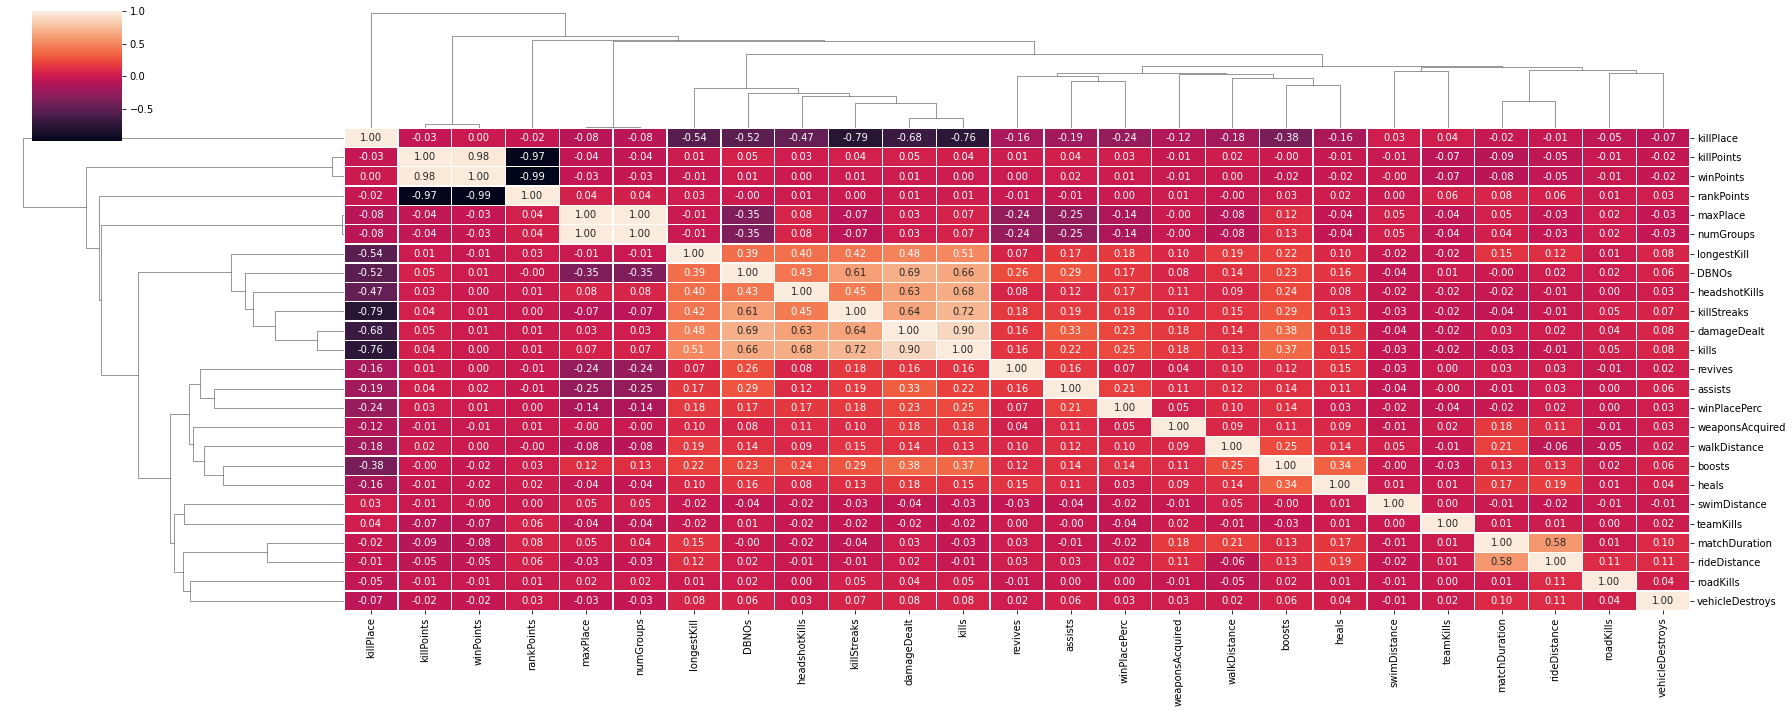

In [38]:
ax = sns.clustermap(top10.corr(), annot=True, linewidths=.5, fmt= '.2f', figsize=(25, 10))
plt.show()

##### Comparison of both clustertmap, for all and TOP 10% shows that the same columns seems to be of significant importance (we assume above 0.6 or below -0.6):

>rankPoints vs killPoints

>kills vs. damage dealt/DBNOs/headshotKills/killPlace

>killStreaks vs. damageDealt/killPlace/kills

>longestKill vs. damageDealt/kills

>walkDistance vs. killPlace

>winPoints vs. killPonts/rankPoints

>winPlacePerc vs. boosts/killPlace/walkDistance/weaponsAquired

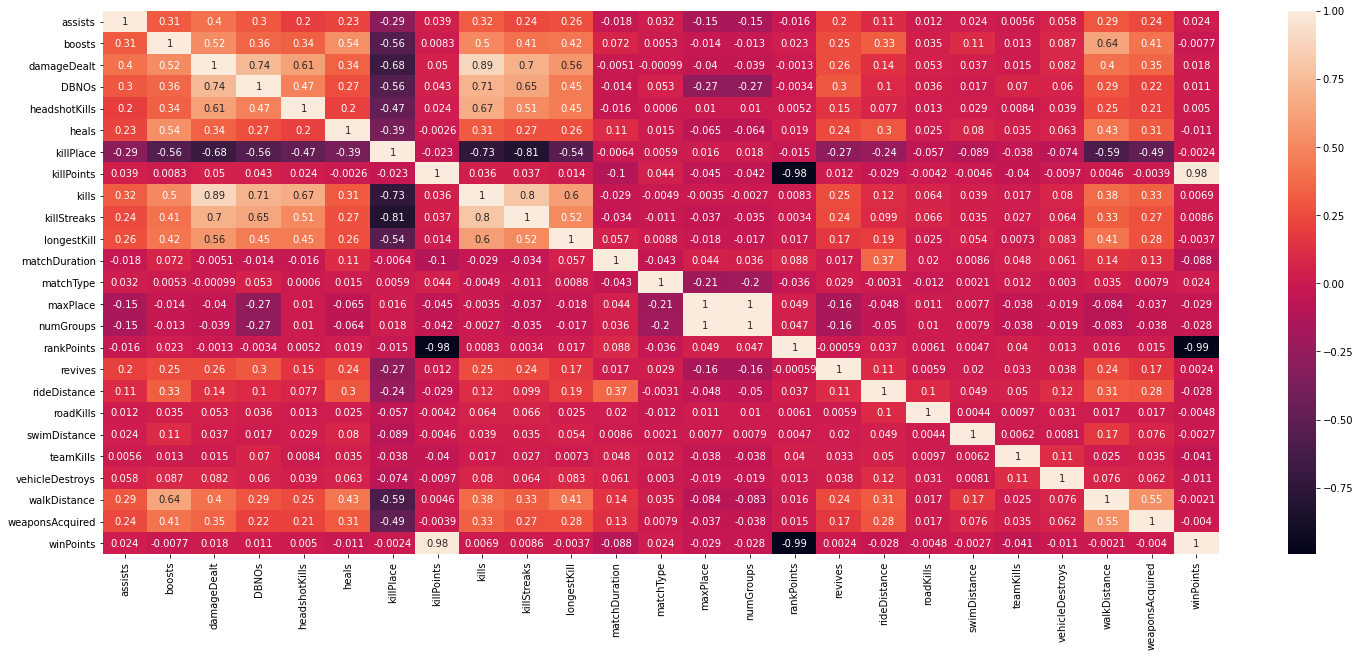

In [33]:
## Checking correlation
figure(figsize=(25,10))
sns.heatmap(data_final.drop('winPlacePerc',axis=1).corr(),annot=True)
plt.show()


ModelBuliding

In [39]:
## Definig independent and dependent variables
X=data_final.iloc[:,0:-1]
y=data_final.winPlacePerc

In [41]:
## Definiging training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [42]:
## Model creation
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X_train,y_train)
y_hat=LR.predict(X_test)

In [43]:
from sklearn.metrics import r2_score

In [44]:
test_score=r2_score(y_test,y_hat)
test_score

0.8323822744151659

In [45]:
## Model Evaluation
##prediciton on training data
y_train_predict=LR.predict(X_train)

train_score=r2_score(y_train,y_train_predict)
train_score

0.8321850313113983

In [46]:
X_train.shape,X_test.shape

((3556344, 25), (889086, 25))

In [47]:
## CHecking adjusted r2 score
train_adjusted_r2 = 1-(1-0.831)*(1111358-1)/(1111358-25-1)
train_adjusted_r2

0.8309961982557867

In [48]:
test_adjusted_r2= 1-(1-0.832)*(1111358-1)/(1111358-25-1)
test_adjusted_r2

0.8319962207513146

## **Decision Tree**

In [50]:
from sklearn.metrics import r2_score, mean_squared_error

In [52]:
from sklearn.tree import DecisionTreeRegressor

In [53]:
DTR= DecisionTreeRegressor()
DTR.fit(X_train,y_train)
y_pred=DTR.predict(X_test)

In [54]:
test_score=r2_score(y_test,y_pred)
test_score

0.8572768135494285

In [55]:
test_adjusted_r2= 1-(1-0.857)*(1111358-1)/(1111358-25-1)
test_adjusted_r2

0.8569967831395119

In [56]:
## Model Evaluation
##prediciton on training data
y_train_predict_D=LR.predict(X_train)

train_score=r2_score(y_train,y_train_predict_D)
train_score

0.8321850313113983

In [57]:
## CHecking adjusted r2 score
train_adjusted_r2 = 1-(1-0.832)*(1111358-1)/(1111358-25-1)
train_adjusted_r2

0.8319962207513146

In [58]:
from sklearn.metrics import mean_squared_error

In [59]:
mean_squared_error(y_test,y_hat)

0.015839938698859198

### **XGBOOST**

In [60]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

X1=data_final.iloc[:,0:-1]
y=data_final.winPlacePerc

col_names = X.columns

transformer = Normalizer().fit(X1)
X1 = transformer.transform(X1)

In [61]:
X1 = pd.DataFrame(X1, columns=col_names)

In [63]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, y, test_size=0.2)

D_train = xgb.DMatrix(X1_train, label=Y1_train)
D_test = xgb.DMatrix(X1_test, label=Y1_test)

In [64]:
param = {
    'eta': 0.15, 
    'max_depth': 5,  
    'num_class': 2} 

steps = 20  # The number of training iterations
model = xgb.train(param, D_train, steps)

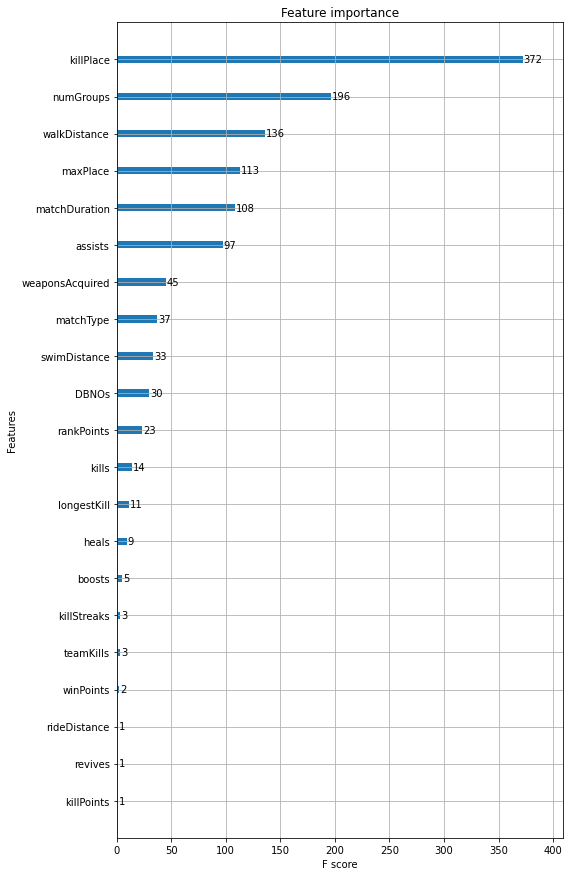

In [65]:
fig, ax1 = plt.subplots(figsize=(8,15))
xgb.plot_importance(model, ax=ax1)
plt.show()

In [67]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("MSE = {}".format(mean_squared_error(Y1_test, best_preds)))

MSE = 0.3183193422248166
